In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

# Set path to the folder containing the low-resolution images
low_res_folder_path = '/content/drive/MyDrive/low_res/'

# Set image dimensions
img_width, img_height = 256, 256

# Read images from folder and create dataset
low_res_filenames = os.listdir(low_res_folder_path)
random.shuffle(low_res_filenames)

num_low_res = len(low_res_filenames)

low_res_images = np.empty((num_low_res, img_height, img_width, 1), dtype=np.float32)



In [3]:
# Function to load and preprocess image
def load_preprocess_image(img_path, target_size=(img_height, img_width)):
    img = load_img(img_path, color_mode='grayscale', target_size=target_size)
    img_arr = img_to_array(img) / 255.0
    return img_arr

for i, low_res_filename in enumerate(low_res_filenames):
    # Load and preprocess low-resolution image
    low_res_img_arr = load_preprocess_image(low_res_folder_path + low_res_filename)
    low_res_images[i] = low_res_img_arr

# Split dataset into train and test sets
train_low_res_images, test_low_res_images = train_test_split(low_res_images, test_size=0.3, random_state=42)



In [10]:
# Implement simple encoder-decoder architecture
inputs = Input(shape=(img_height, img_width, 1))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)

# Decoder
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9), loss='mae')
model.summary()



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      640       
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      18464     
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 256, 256, 32)     9248      
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 256, 256, 1)      289       
 ranspose)                                                       
                                                                 
Total params: 28,641
Trainable params: 28,641
Non-trainable

In [11]:
# Train the model
batch_size = 16
epochs = 300

# Train the model
history = model.fit(train_low_res_images, train_low_res_images,
                    batch_size=batch_size,
                    validation_data=(test_low_res_images, test_low_res_images),
                    epochs=epochs,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)],
                    verbose=1)



Epoch 1/300
34/34 [==============================] - 2s 37ms/step - loss: 41.7706 - val_loss: 41.9692
Epoch 2/300
34/34 [==============================] - 1s 26ms/step - loss: 41.7250 - val_loss: 41.9320
Epoch 3/300
34/34 [==============================] - 1s 26ms/step - loss: 41.6899 - val_loss: 41.8992
Epoch 4/300
34/34 [==============================] - 1s 26ms/step - loss: 41.6592 - val_loss: 41.8707
Epoch 5/300
34/34 [==============================] - 1s 26ms/step - loss: 41.6325 - val_loss: 41.8459
Epoch 6/300
34/34 [==============================] - 1s 26ms/step - loss: 41.6093 - val_loss: 41.8243
Epoch 7/300
34/34 [==============================] - 1s 26ms/step - loss: 41.5890 - val_loss: 41.8055
Epoch 8/300
34/34 [==============================] - 1s 26ms/step - loss: 41.5715 - val_loss: 41.7892
Epoch 9/300
34/34 [==============================] - 1s 26ms/step - loss: 41.5562 - val_loss: 41.7750
Epoch 10/300
34/34 [==============================] - 1s 26ms/step - loss: 41.5429

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 154ms/step


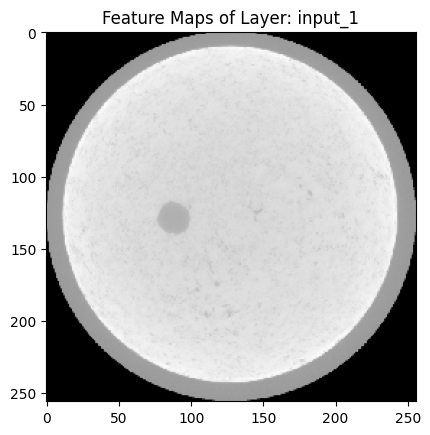

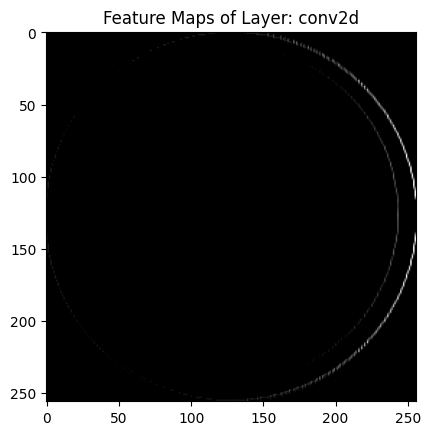

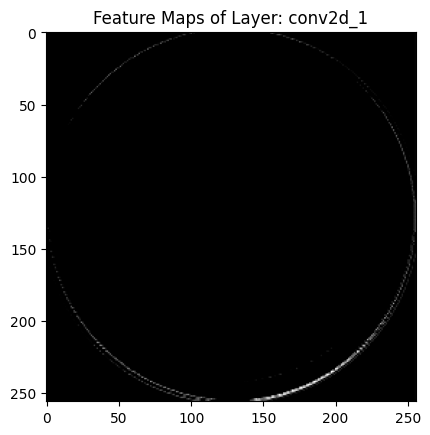

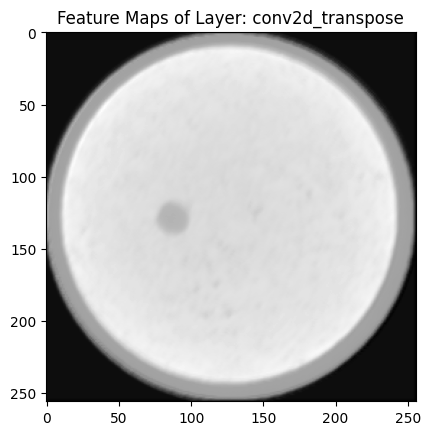

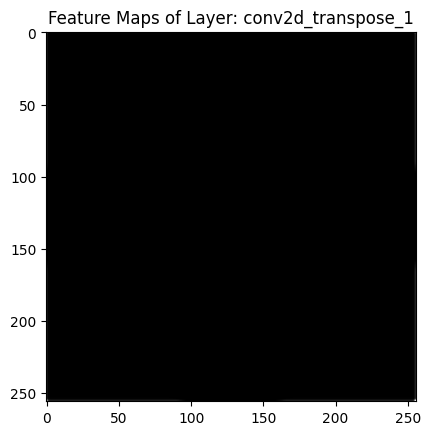

In [6]:
# After training the model, create a new model to visualize the intermediate outputs
intermediate_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers])

# Select a random index from the test set
index = np.random.randint(test_low_res_images.shape[0])

# Predict the intermediate outputs for the selected image
intermediate_outputs = intermediate_model.predict(test_low_res_images[index:index+1])

# Display the feature maps for each layer
for layer, feature_maps in zip(model.layers, intermediate_outputs):
    # Plot the feature maps
    plt.imshow(feature_maps[0, :, :, 0], cmap='gray')
    plt.title(f"Feature Maps of Layer: {layer.name}")
    plt.show()



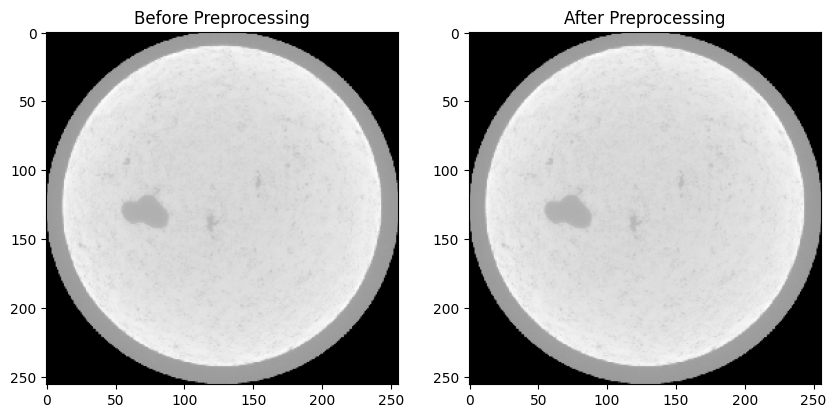

In [7]:
# Visualize the images before and after the preprocessing step
plt.figure(figsize=(10, 5))

# Before preprocessing
plt.subplot(1, 2, 1)
plt.imshow(load_img(low_res_folder_path + low_res_filenames[0], color_mode='grayscale', target_size=(img_height, img_width)), cmap='gray')
plt.title('Before Preprocessing')

# After preprocessing
plt.subplot(1, 2, 2)
plt.imshow(load_preprocess_image(low_res_folder_path + low_res_filenames[0]), cmap='gray')
plt.title('After Preprocessing')

plt.show()